# Decision tree

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st

In [3]:
model_name = "dtree"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline including:
- use randomised search to find optimal hyperparameters
- train best model on all training data

In [7]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [8]:
regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
param_dist = {'max_depth': [None,2,4,6,8,10,12,14,16,18,20],
              'min_samples_split': st.randint(2, 50),
              'min_samples_leaf': st.randint(1, 100),
              'max_features': range(3,X.shape[1]+1)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=100,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.7s finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_s...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

Save model to AML shared directory

In [10]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [11]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
71,0.811000,0.009834,-8833.642205,-1070.804821,20,16,1,9,"{'max_depth': 20, 'min_samples_split': 9, 'max...",1,-11743.446840,-1324.712747,-7417.529510,-1044.822914,-7339.950266,-842.878800,0.365328,6.511332e-03,2057.786334,197.563969
44,0.639333,0.005335,-9764.134963,-6362.915830,12,17,6,45,"{'max_depth': 12, 'min_samples_split': 45, 'ma...",2,-13567.887087,-8140.869108,-8324.623783,-5983.534238,-7399.894020,-4964.344146,0.279035,1.178201e-03,2716.023926,1324.267219
69,0.682333,0.003668,-11188.256064,-6517.504399,12,14,13,3,"{'max_depth': 12, 'min_samples_split': 3, 'max...",3,-17124.302143,-8671.806455,-9225.585043,-6461.331825,-7214.881008,-4419.374916,0.257777,2.360231e-04,4276.931530,1736.502235
40,0.626000,0.004835,-11443.668102,-8617.199546,14,16,25,20,"{'max_depth': 14, 'min_samples_split': 20, 'ma...",4,-15512.585517,-11071.711024,-10223.800666,-8429.611828,-8594.618123,-6350.275786,0.304455,1.179719e-03,2953.035234,1932.076524
68,0.662833,0.008669,-11848.946350,-7453.787340,18,13,3,49,"{'max_depth': 18, 'min_samples_split': 49, 'ma...",5,-17137.206842,-10395.433843,-10001.706567,-6906.870807,-8407.925640,-5059.057370,0.370406,5.892635e-03,3795.550789,2212.625399
90,0.389832,0.004668,-11916.743677,-8264.815093,10,13,16,24,"{'max_depth': 10, 'min_samples_split': 24, 'ma...",6,-15643.216517,-9551.551352,-10607.437101,-8336.956213,-9499.577414,-6905.937714,0.187644,1.700999e-03,2673.547972,1081.271208
28,0.410999,0.005167,-12452.352266,-7520.359661,20,13,10,44,"{'max_depth': 20, 'min_samples_split': 44, 'ma...",7,-20456.853513,-11248.191853,-8749.678688,-6484.057412,-8150.524596,-4828.829719,0.225164,2.357189e-03,5665.320030,2721.212268
75,0.551834,0.005669,-13686.743038,-10547.721512,20,16,33,10,"{'max_depth': 20, 'min_samples_split': 10, 'ma...",8,-19321.211333,-13869.973657,-12137.608243,-10006.665267,-9601.409537,-7766.525613,0.293154,1.841912e-03,4116.511524,2520.922569
72,0.605832,0.004501,-13690.462733,-10622.273248,18,15,34,48,"{'max_depth': 18, 'min_samples_split': 48, 'ma...",9,-19551.214352,-14179.986113,-11383.815682,-9644.919225,-10136.358164,-8041.914408,0.303328,7.067186e-04,4175.351859,2599.409770
67,0.480166,0.011834,-14129.414257,-9508.965414,14,12,21,45,"{'max_depth': 14, 'min_samples_split': 45, 'ma...",10,-22998.544643,-14642.473848,-10203.335964,-7658.899910,-9186.362165,-6225.522483,0.304685,6.561743e-03,6285.149920,3676.803353


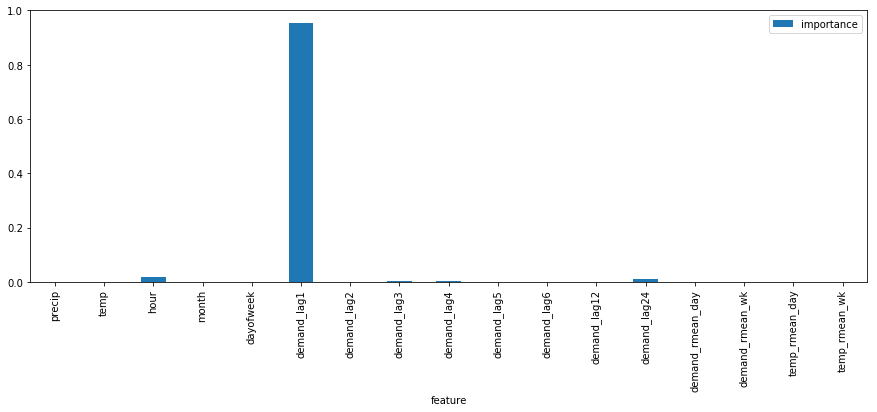

In [12]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5))
plt.show()